# 呼吸相検出モデル構築　プログラム

# Xgboostを用いた呼吸相分類：健常者のみ

  
本ソースコードでは,聴診器試作機により取得した健常者または間質性肺炎患者の肺音データの中から呼吸相を識別する機械学習モデルを構築する.


データの形式の違いにより読み込みができずに終了したため次回に実行結果を提示する.  
肺音データはmel-スペクトログラムに変換した後, 一定幅のセグメントに分割する.セグメント画像を患者ごとに保存する.  
また,各セグメントに吸気相および呼気相が含まれているかどうかを示すラベル情報とセグメント画像へのパスを示したCSVファイルを事前に作成し,本ソースコードで利用する.  
呼吸相情報は医師の教師データを使用した.


# 9月20,22日の作業内容記載

## ライブラリのインポート

In [1]:
import pandas as pd
import numpy as np
from PIL import Image
import sys
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import xgboost as xgb
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
warnings.filterwarnings('ignore')
#%matplotlibib inline
sns.set()

### テストファイルの指定

In [2]:
test_file = ["normal_m04","normal06"]

## 呼吸相画像へのパスとラベル情報が付与されたCSVファイルの読み込み
### TrainとTestで使用するデータを抽出

In [3]:
df_normal = pd.read_csv('Data/mel_spec_breath/csv/breath_mel_spec_normal.csv')
#df_train_1 = df.iloc[1320:1980,:]
#df_train_2 = df.iloc[2414:2942,:]
#df_train_3 = df.iloc[1056:1320,:]
#df_train_4 = df.iloc[1452:2414,:]
#df_train = pd.concat([df_2023_normal,df_2022_normal,df_2022_crack],ignore_index=True)#,df_train_3,df_train_4]
df_normal.head(200)

,index,image_name,patient,state,time,patient_No,breath_phase
0,1,Data/mel_spec_breath/inhall/normal_m01_Ch0_gra...,normal_m01,0,0,0,1
1,2,Data/mel_spec_breath/inhall/normal_m01_Ch0_gra...,normal_m01,0,0,0,1
2,3,Data/mel_spec_breath/inhall/normal_m01_Ch0_gra...,normal_m01,0,0,0,1
3,4,Data/mel_spec_breath/inhall/normal_m02_Ch0_gra...,normal_m02,0,0,0,1
4,5,Data/mel_spec_breath/inhall/normal_m02_Ch0_gra...,normal_m02,0,0,0,1
...,...,...,...,...,...,...,...
62,63,Data/mel_spec_breath/exhall/normal06_Ch0_gray_...,normal06,0,0,0,0
63,64,Data/mel_spec_breath/exhall/normal06_Ch0_gray_...,normal06,0,0,0,0
64,65,Data/mel_spec_breath/exhall/normal06_Ch0_gray_...,normal06,0,0,0,0
65,66,Data/mel_spec_breath/exhall/normal06_Ch0_gray_...,normal06,0,0,0,0


In [4]:
df_train = df_normal[(df_normal["patient"]!=test_file[0]) & (df_normal["patient"]!=test_file[1])]
train_num = len(df_train)
df_train.reset_index(drop=True, inplace=True)
print(train_num)
df_train.head()

50


,index,image_name,patient,state,time,patient_No,breath_phase
0,1,Data/mel_spec_breath/inhall/normal_m01_Ch0_gra...,normal_m01,0,0,0,1
1,2,Data/mel_spec_breath/inhall/normal_m01_Ch0_gra...,normal_m01,0,0,0,1
2,3,Data/mel_spec_breath/inhall/normal_m01_Ch0_gra...,normal_m01,0,0,0,1
3,4,Data/mel_spec_breath/inhall/normal_m02_Ch0_gra...,normal_m02,0,0,0,1
4,5,Data/mel_spec_breath/inhall/normal_m02_Ch0_gra...,normal_m02,0,0,0,1


In [5]:
df_test = df_normal[(df_normal["patient"]==test_file[0]) | (df_normal["patient"]==test_file[1])]
test_num = len(df_test)
df_test.reset_index(drop=True, inplace=True)
print(test_num)
df_test

17


,index,image_name,patient,state,time,patient_No,breath_phase
0,10,Data/mel_spec_breath/inhall/normal_m04_Ch0_gra...,normal_m04,0,0,0,1
1,11,Data/mel_spec_breath/inhall/normal_m04_Ch0_gra...,normal_m04,0,0,0,1
2,12,Data/mel_spec_breath/inhall/normal_m04_Ch0_gra...,normal_m04,0,0,0,1
3,29,Data/mel_spec_breath/inhall/normal06_Ch0_gray_...,normal06,0,0,0,1
4,30,Data/mel_spec_breath/inhall/normal06_Ch0_gray_...,normal06,0,0,0,1
5,31,Data/mel_spec_breath/inhall/normal06_Ch0_gray_...,normal06,0,0,0,1
6,32,Data/mel_spec_breath/inhall/normal06_Ch0_gray_...,normal06,0,0,0,1
7,33,Data/mel_spec_breath/inhall/normal06_Ch0_gray_...,normal06,0,0,0,1
8,34,Data/mel_spec_breath/inhall/normal06_Ch0_gray_...,normal06,0,0,0,1
9,44,Data/mel_spec_breath/exhall/normal_m04_Ch0_gra...,normal_m04,0,0,0,0


### 可視化テスト用データの抽出
試作機を用いて収集した健常者2名の肺音データ   

In [6]:
path_test_1 = "../Spectrogram/Prototype/mel_spec/"+test_file[0]+"_Ch0_mel_spec.png"
path_test_2 = "../Spectrogram/Prototype/mel_spec/"+test_file[1]+"_Ch0_mel_spec.png"

test_1 = cv2.imread(path_test_1)
test_2 = cv2.imread(path_test_2)

test_gray_1 = cv2.cvtColor(test_1, cv2.COLOR_BGR2GRAY)
test_gray_2 = cv2.cvtColor(test_2, cv2.COLOR_BGR2GRAY)
test_gray_1 = test_gray_1[128:256,:]
test_gray_2 = test_gray_2[128:256,:]

(128, 1584)


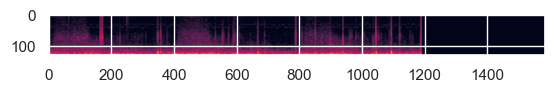

In [7]:
plt.imshow(test_gray_1)
print(test_gray_1.shape)

(128, 1584)


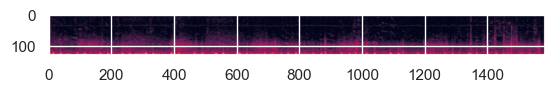

In [8]:
plt.imshow(test_gray_2)
print(test_gray_2.shape)

## 画像を一次元配列のデータとして格納するための訓練用配列とテスト用配列を初期化して用意  
## (訓練・テストデータ用)

In [9]:
count=0
num_of_data_total=train_num
N_col=128
X = np.zeros((num_of_data_total, N_col))
y = np.zeros((num_of_data_total))
print(X.shape)
print(y.shape)

(50, 128)
(50,)


In [10]:
split_num = 186+1#173
num_of_data_total=split_num
N_col=128
X_test_1 = np.zeros((num_of_data_total, N_col))
y_test_1 = np.zeros((num_of_data_total))
X_test_2 = np.zeros((num_of_data_total, N_col))
y_test_2 = np.zeros((num_of_data_total))
print(X_test_1.shape)
print(y_test_1.shape)
print(X_test_2.shape)
print(y_test_2.shape)

(187, 128)
(187,)
(187, 128)
(187,)


### pathの確認

In [11]:
df_train['image_name']

0     Data/mel_spec_breath/inhall/normal_m01_Ch0_gra...
1     Data/mel_spec_breath/inhall/normal_m01_Ch0_gra...
2     Data/mel_spec_breath/inhall/normal_m01_Ch0_gra...
3     Data/mel_spec_breath/inhall/normal_m02_Ch0_gra...
4     Data/mel_spec_breath/inhall/normal_m02_Ch0_gra...
5     Data/mel_spec_breath/inhall/normal_m02_Ch0_gra...
6     Data/mel_spec_breath/inhall/normal_m03_Ch0_gra...
7     Data/mel_spec_breath/inhall/normal_m03_Ch0_gra...
8     Data/mel_spec_breath/inhall/normal_m03_Ch0_gra...
9     Data/mel_spec_breath/inhall/normal01_Ch0_gray_...
10    Data/mel_spec_breath/inhall/normal01_Ch0_gray_...
11    Data/mel_spec_breath/inhall/normal01_Ch0_gray_...
12    Data/mel_spec_breath/inhall/normal01_Ch0_gray_...
13    Data/mel_spec_breath/inhall/normal03_Ch0_gray_...
14    Data/mel_spec_breath/inhall/normal03_Ch0_gray_...
15    Data/mel_spec_breath/inhall/normal03_Ch0_gray_...
16    Data/mel_spec_breath/inhall/normal03_Ch0_gray_...
17    Data/mel_spec_breath/inhall/normal03_Ch0_g

## 画像データの一次元配列化
一次元化の方法により精度が変わるのでデータに適した方法を選択する必要がある.  
検出したい音の特徴が抽出できる方法は音の性質により変化する.

In [12]:
print("Window幅:\t"+str((20/1584)*96))
print("HopSize:\t"+str((20/1584)*8))

Window幅:	1.2121212121212122
HopSize:	0.10101010101010101


### 訓練データの1次元配列化

In [13]:
for i in df_train['image_name']:
    im = cv2.imread(i)
    im_gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    #plt.imshow(im_gray)
    #print(i)
    #p=np.array(Image.open(i))
    #im_array = np.var(im_gray,axis=1)#時間軸方向の分散で一次元化
    im_array = np.mean(im_gray,axis=1)#時間軸方向の平均値で一次元化
    #print(im_array.shape)
    #im_array = np.ravel(im_gray)#各時間軸方向の連結で一次元化
    #im_array = np.amax(im_gray,axis=1)#時間軸方向の最大値で一次元化
    X[count,:] = im_array
    y[count] = df_train['breath_phase'][count]
    count+=1
print(count)

50


In [14]:
print(im_array.shape)
y = y.astype(np.int64)
print(y)

(128,)
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]


### テストデータの一次元配列化

In [15]:
count=0
cut_size = 96
hop_range = 8

for i in range(split_num):
    im = test_gray_1[:,i*hop_range:i*hop_range+cut_size]
    #p=np.array(Image.open(i))
    #im_array = np.var(im,axis=1)#時間軸方向の分散で一次元化
    im_array = np.mean(im,axis=1)#時間軸方向の平均値で一次元化
    #print(im_array.shape)
    #im_array = np.ravel(im)#各時間軸方向の連結で一次元化
    #im_array = np.amax(im,axis=1)#時間軸方向の最大値で一次元化
    X_test_1[count,:] = im_array
    count+=1
print(i)   

count=0
for i in range(split_num):
    im = test_gray_2[:,i*hop_range:i*hop_range+cut_size]
    #p=np.array(Image.open(i))
    #im_array = np.var(im,axis=1)#時間軸方向の分散で一次元化
    im_array = np.mean(im,axis=1)#時間軸方向の平均値で一次元化
    #print(im_array.shape)
    #im_array = np.ravel(im)#各時間軸方向の連結で一次元化
    #im_array = np.amax(im,axis=1)#時間軸方向の最大値で一次元化
    X_test_2[count,:] = im_array
    count+=1
print(i)

186
186


### データフレーム化

In [16]:
df_X = pd.DataFrame(X)
df_test_1 = pd.DataFrame(X_test_1)
df_test_2 = pd.DataFrame(X_test_2)
#df_X

## 各ラベルの比率を表示
非捻発音：0  
捻発音：1

In [17]:
df_train["breath_phase"].value_counts()

1    25
0    25
Name: breath_phase, dtype: int64

## ラベルの比率を揃えるためのアンダーサンプリング

In [18]:
'''
from imblearn.under_sampling import RandomUnderSampler
neg_count_train = df_train["breath_phase"].value_counts()[1]
strategy = {0:neg_count_train, 1:neg_count_train}
rus = RandomUnderSampler(random_state=2, sampling_strategy=strategy)
X_res, y_res = rus.fit_resample(X,y)
print("サンプリング後のデータ数:"+str(len(X_res)))
'''

'\nfrom imblearn.under_sampling import RandomUnderSampler\nneg_count_train = df_train["breath_phase"].value_counts()[1]\nstrategy = {0:neg_count_train, 1:neg_count_train}\nrus = RandomUnderSampler(random_state=2, sampling_strategy=strategy)\nX_res, y_res = rus.fit_resample(X,y)\nprint("サンプリング後のデータ数:"+str(len(X_res)))\n'

## 訓練データと検証データへの分割

In [19]:
X_train, X_eval, y_train, y_eval = train_test_split(df_X, y, test_size=0.30, stratify=y, random_state=0)
#X_train, X_eval, y_train, y_eval = train_test_split(feature[:,0:20], y, test_size=0.3, stratify=y, random_state=3)
#X_train, X_eval, y_train, y_eval = train_test_split(X_res, y_res, test_size=0.2, stratify=y_res, random_state=0)

## XGboostモデルの作成(モデルの超パラメータはここで設定)

In [20]:
fit_params ={'verbose':True,
            'early_stopping_rounds':10,
            'eval_metric':'logloss',
            'eval_set':[(X_eval, y_eval)]
            }
model = XGBClassifier(eta = 0.01,max_depth=3,min_child_weigh=10,booster='gbtree',objective='binary:logistic',use_label_encoder=False,random_state=0)

## 交差検証による簡易な精度確認
※メモリを消費が大きいので注意

In [21]:
'''
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score


cv = StratifiedKFold(n_splits=5,shuffle=True, random_state=0)
scoring = 'accuracy'
scores = cross_val_score(model, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1, fit_params=fit_params)
print(f'scores={scores}')
print(f'average_score={np.mean(scores)}')
'''

"\nfrom sklearn.model_selection import KFold\nfrom sklearn.model_selection import StratifiedKFold\nfrom sklearn.model_selection import cross_val_score\n\n\ncv = StratifiedKFold(n_splits=5,shuffle=True, random_state=0)\nscoring = 'accuracy'\nscores = cross_val_score(model, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1, fit_params=fit_params)\nprint(f'scores={scores}')\nprint(f'average_score={np.mean(scores)}')\n"

## 学習

In [22]:
%%time
eval_set = [(X_eval, y_eval)]
model.fit(X_train, y_train, early_stopping_rounds=100, eval_set=eval_set, verbose=True)#,sample_weight=weight_train

[21:09:48] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "min_child_weigh" } are not used.

[0]	validation_0-logloss:0.69238
[1]	validation_0-logloss:0.69230
[2]	validation_0-logloss:0.69223
[3]	validation_0-logloss:0.69158
[4]	validation_0-logloss:0.69157
[5]	validation_0-logloss:0.69161
[6]	validation_0-logloss:0.69106
[7]	validation_0-logloss:0.69054
[8]	validation_0-logloss:0.69063
[9]	validation_0-logloss:0.69080
[10]	validation_0-logloss:0.69038
[11]	validation_0-logloss:0.69060
[12]	validation_0-logloss:0.69025
[13]	validation_0-logloss:0.69045
[14]	validation_0-logloss:0.69069
[15]	validation_0-logloss:0.69041
[16]	validation_0-logloss:0.69076
[17]	validation_0-logloss:0.69055
[18]	validation_0-logloss:0.69095
[19]	validation_0-logloss:0.69080
[20]	validation_0-logloss:0.69115
[21]	validation_0-logloss:0.69104
[22]	validation_0-logloss:0.69143
[23]	validation_0-logloss:0.69194
[24]	

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.01, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weigh=10, min_child_weight=None,
              missing=nan, monotone_constraints=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, ...)

## 変数重要度の出力
上位100変数  
f1=周波数1Hz

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

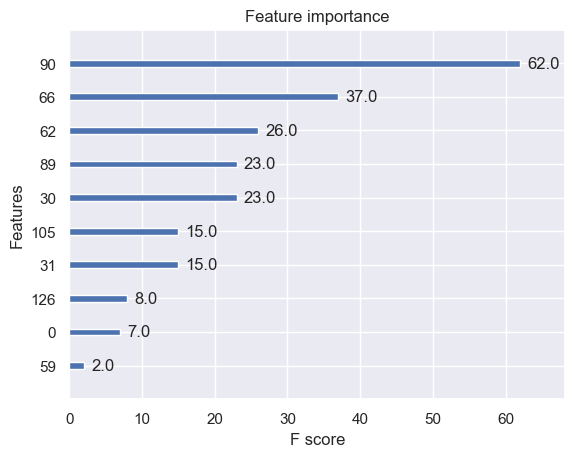

In [23]:
fig, ax = plt.subplots()#figsize=(28, 80)
xgb.plot_importance(model,ax=ax,max_num_features=10)

### 結果表示用時間軸の生成

In [24]:
ti = np.linspace(0.0,20.0,187)
len(ti)

187

## 訓練したモデルを用いてテストデータと可視化用テストデータを予測

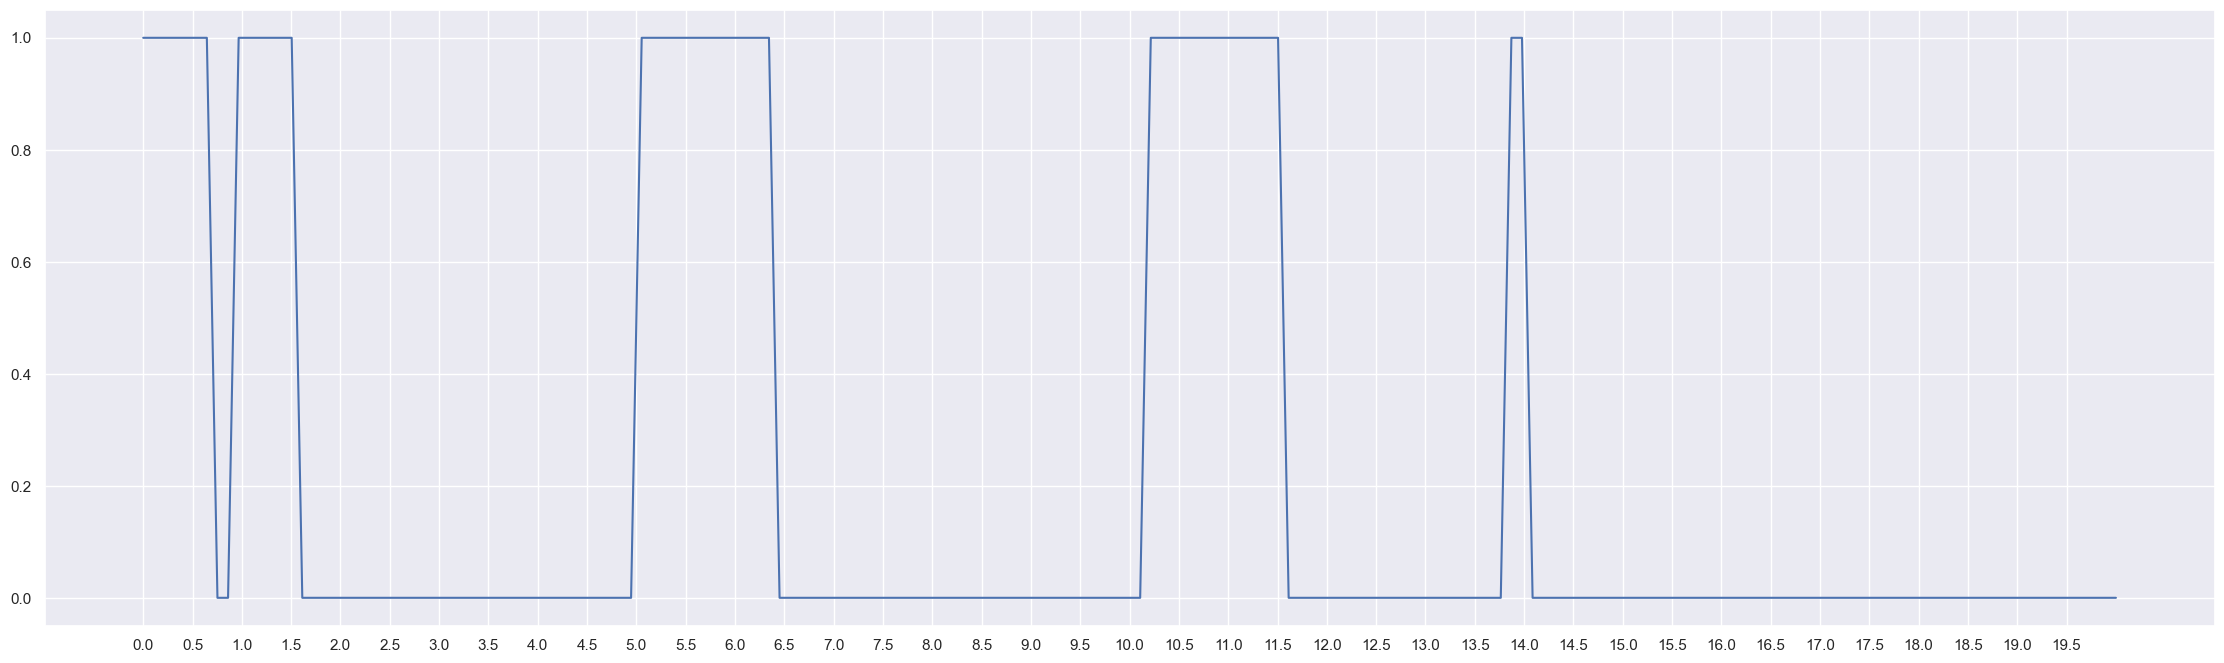

In [25]:
from sklearn import metrics
#y_pred = model.predict_proba(X_test)
#y_pred_max = np.argmax(y_pred, axis=1)
y_pred_1 = model.predict_proba(X_test_1)
y_pred_1 = np.argmax(y_pred_1, axis=1)
#print("Train :", model.score(X_train, y_train))
#print("Test :", model.score(X_t, y_t))
fig, ax = plt.subplots(figsize=(28, 8))
plt.plot(ti, y_pred_1)
ax.set_xticks(np.arange(0.0, 20.0, 0.5))
plt.show()

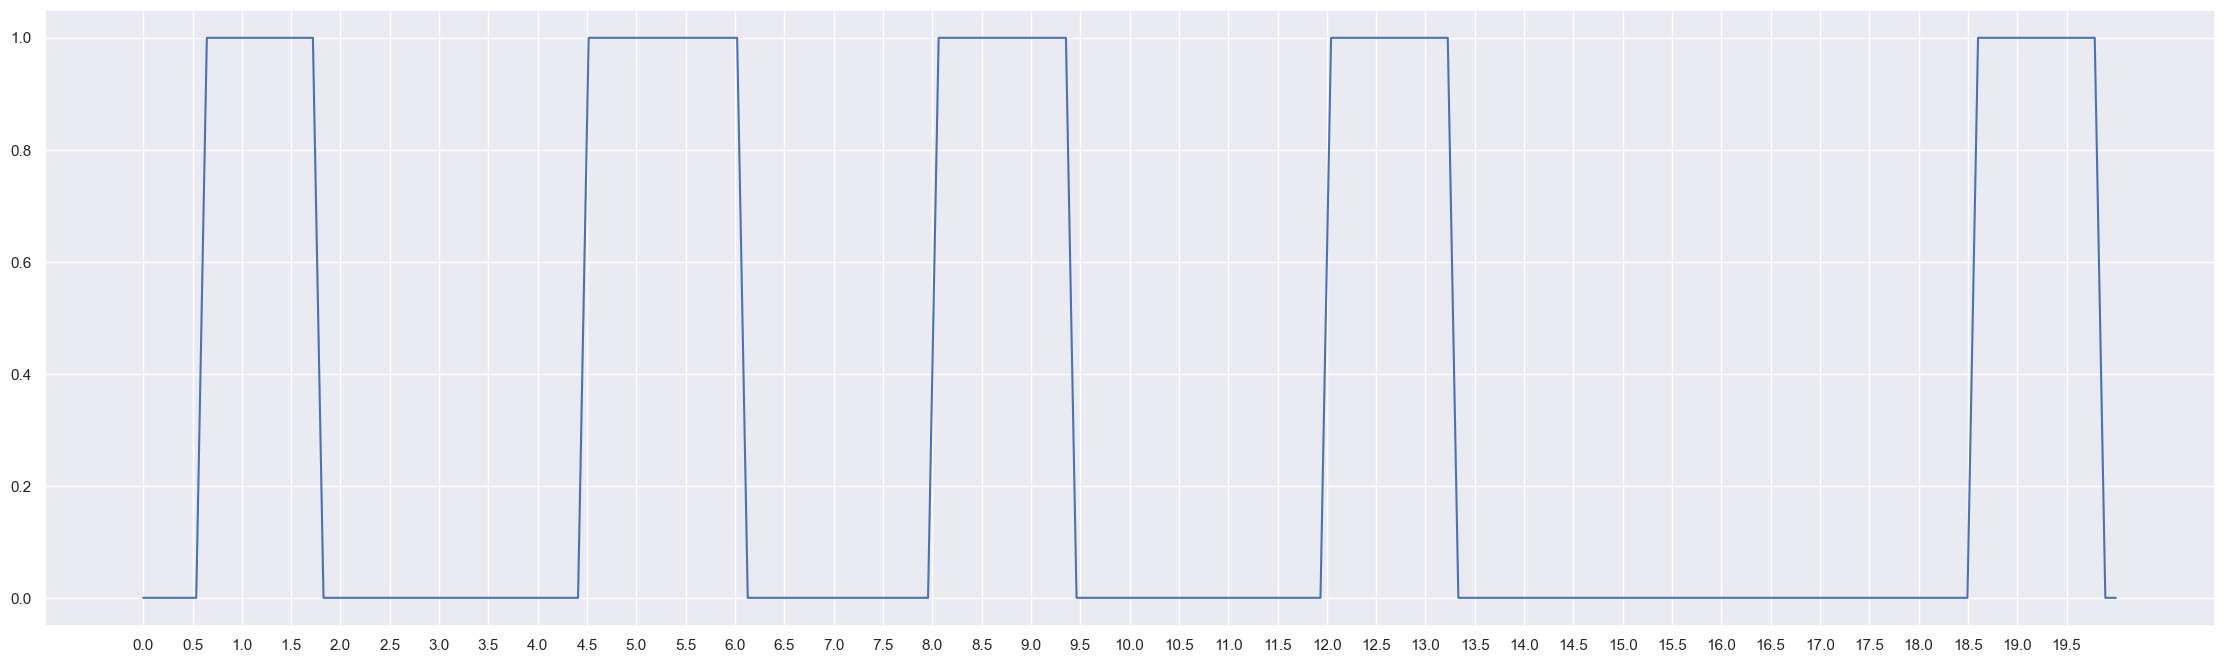

In [26]:
y_pred_2 = model.predict_proba(X_test_2)
y_pred_2 = np.argmax(y_pred_2, axis=1)
fig, ax = plt.subplots(figsize=(28, 8))
plt.plot(ti, y_pred_2)
ax.set_xticks(np.arange(0.0, 20.0, 0.5))
#ax.set_xticks(np.arange(0, 172, ))
plt.show()

## 9/20
## 新しいデータによる呼吸相識別精度算出
###  6件の新しい健常者データに対して、過去作成した決定木モデルの呼吸相識別を実施

健常者に対して過去作成した決定木モデルの呼吸相識別を実施した。  
過去にサウンドアナライザー取得した肺音は本実験では用いていない。  
理由としてサウンドアナライザーと聴診器試作機では集音性能やノイズ処理性能、サンプリング周波数が異なるため同じデバイスから得た。  
音による機械学習モデルの構築が比較条件として必要になるためである。  
過去のサウンドアナライザーから得た肺音で鍛えた機械学習モデルが妥当であることは示せているため、聴診器試作機から得た肺音の呼吸相を精度良く分離できた場合に  
聴診器試作機がサウンドアナライザーと同等またはそれ以上の性能で肺音の特徴を収集できていることを示せる。  


-----
## モデルの精度評価

In [27]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
pd.set_option("display.max_colwidth",100000)

### 教師用ラベルCSVファイルの読み込み

In [28]:
ev  = pd.read_csv('Data/csv/breath_phase_mel_spec_normal.csv',index_col=False)
ev

,patient,inhalation,exhalation,patient_No
0,normal01,"[1.7, 5.75, 9.2, 12.5]",NaN,0
1,normal02,NaN,NaN,0
2,normal03,NaN,NaN,0
3,normal04,NaN,NaN,0
4,normal05,NaN,NaN,0
5,normal06,"[1.0,2.0,4.8,6.1,8.0,9.4,11.6,13.3,15.0,16.3,18.2,19.8]",NaN,0
6,normal_m01,NaN,NaN,0
7,normal_m02,NaN,NaN,0
8,normal_m03,NaN,NaN,0
9,normal_m04,"[0,1.7,5.0,6.6,10.1,11.8]",NaN,0


### 吸気情報の抽出

In [29]:
tf_1 = ev[ev["patient"]==test_file[0]]
tf_1 = tf_1["inhalation"]
tf_1 = tf_1.to_string(index=False)
tf_1 = eval(tf_1)
tf_1

[0, 1.7, 5.0, 6.6, 10.1, 11.8]

In [30]:
tf_2 = ev[ev["patient"]==test_file[1]]
tf_2 = tf_2["inhalation"]
tf_2 = tf_2.to_string(index=False)
tf_2 = eval(tf_2)
tf_2

[1.0, 2.0, 4.8, 6.1, 8.0, 9.4, 11.6, 13.3, 15.0, 16.3, 18.2, 19.8]

In [32]:
ev_s = [[],[]]
for i in range(len(ev_s)):
    
    f = 0
    flag= 0
    
    for j in range(187):
        if i == 0:
            if f==len(tf_1):
                ev_s[i].append(0)
                continue
            if ti[j]>=tf_1[f] and ti[j]<=tf_1[f+1]:
                ev_s[i].append(1)
                flag = 1
            else:
                ev_s[i].append(0)
                if flag == 1:
                    f+=2
                flag = 0

        if i == 1:
            if f==len(tf_2):
                ev_s[i].append(0)
                continue
            if ti[j]>=tf_2[f] and ti[j]<=tf_2[f+1]:
                ev_s[i].append(1)
                flag = 1
            else:
                ev_s[i].append(0)
                if flag == 1:
                    f+=2
                flag = 0


In [33]:
ind = 0
for i in range(len(ti)):
    if ti[i] > 15.0:
        break
ind = i

ev_s[0] = ev_s[0][0:140]
y_pred_1 = y_pred_1[0:140]

In [34]:
ev_axis_15 = np.linspace(0.0, 15.0, 140)

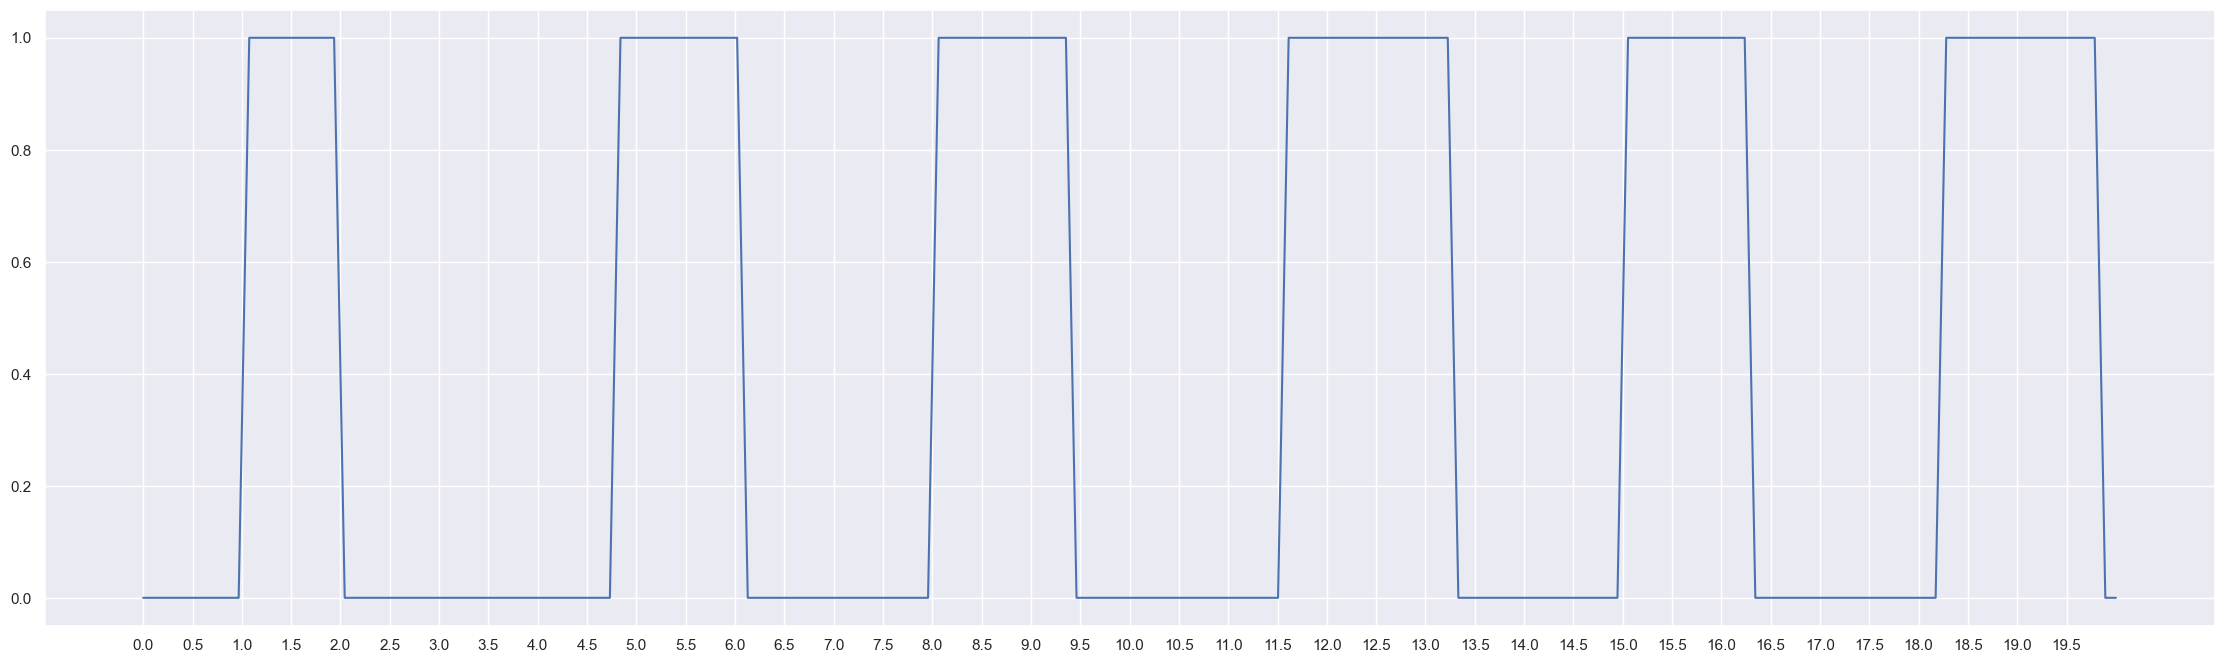

In [35]:
fig, ax = plt.subplots(figsize=(28, 8))
plt.plot(ev_axis, ev_s[1])
ax.set_xticks(np.arange(0.0, 20.0, 0.5))
plt.show()

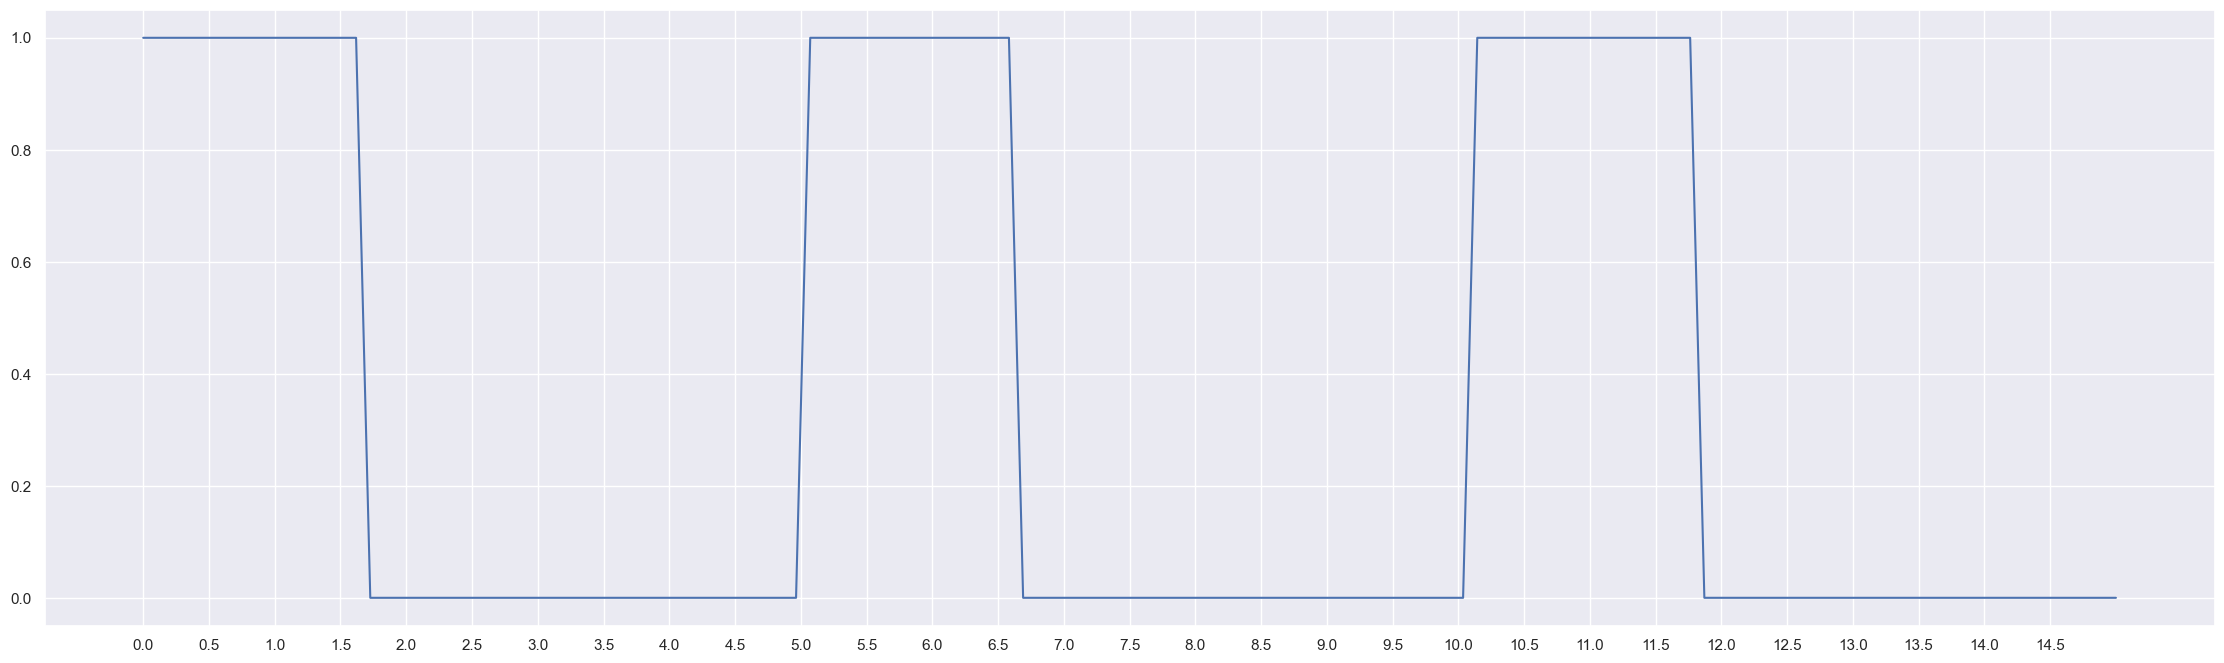

In [36]:
fig, ax = plt.subplots(figsize=(28, 8))
plt.plot(ev_axis_15, ev_s[0])
ax.set_xticks(np.arange(0.0, 15.0, 0.5))
plt.show()

### テストデータの精度評価指標（適合率,再現率,F1スコア,正解率） 

### テストデータ1

In [37]:
c_rep = classification_report(ev_s[0], y_pred_1)
print(c_rep)

              precision    recall  f1-score   support

           0       0.92      0.98      0.95        93
           1       0.95      0.83      0.89        47

    accuracy                           0.93       140
   macro avg       0.94      0.90      0.92       140
weighted avg       0.93      0.93      0.93       140



### テストデータ2

In [38]:
c_rep = classification_report(ev_s[1], y_pred_2)
print(c_rep)

              precision    recall  f1-score   support

           0       0.83      0.94      0.88       110
           1       0.89      0.73      0.80        77

    accuracy                           0.85       187
   macro avg       0.86      0.83      0.84       187
weighted avg       0.85      0.85      0.85       187



### 総合評価

In [39]:
all_ev = np.append(ev_s[0],ev_s[1])
all_pred = np.append(y_pred_1,y_pred_2)
c_rep = classification_report(all_ev, all_pred)
print(c_rep)

              precision    recall  f1-score   support

           0       0.87      0.96      0.91       203
           1       0.91      0.77      0.83       124

    accuracy                           0.88       327
   macro avg       0.89      0.86      0.87       327
weighted avg       0.89      0.88      0.88       327



## 9/22
## 新しいデータによる呼吸相識別精度算出
###  6件の新しい健常者データによる、過去作成したモデルでの呼吸相識別結果を報告スライドに記載する作業を実施

健常者2件のテストデータを比較したところ、およそ80%以上のF1スコアを導出することができた。  
適合率と再現率を比較するとやや吸気相の検出もれが多く発生しているため調査したところ、呼吸相の境目で呼気と判定されてしまう傾向が見られた。  
呼吸相の境目に対する学習のアプローチを考える必要がある。